In [110]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random

In [111]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct DESParameter{FT}
    td::FT = 1e-2
    tr::FT = 5e-3
end

@kwdef mutable struct DES{FT}
    param::DESParameter = DESParameter{FT}()
    N::UInt32 # ニューロンの数
    r_double::Vector{FT} = zeros(N)
    hr::Vector{FT} = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function DESupdate!(variable::DES, param::DESParameter, r_double, hr, spike::Vector, dt)
    @unpack N = variable
    @unpack td, tr = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        r_double[i] = r_double[i]*(1-dt/tr) + hr[i]*dt
        hr[i] = hr[i]*(1-dt/td) + spike[i]/(tr*td)
    end
end

DESupdate! (generic function with 1 method)

In [112]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Delay_Connection{FT}
    N::UInt32 # ニューロンの数
    delay::Float32
    dt::Float32
    nt_delay::UInt32 = round(Int64,delay/dt)
    state::Matrix{Bool} = zeros(N, nt_delay)
    out = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function Delay_Connection_call!(variable::Delay_Connection, x::Vector{Bool}, dt)
    @unpack N,delay,dt,nt_delay,state,out = variable
    #out = zeros(N, 1) # mutableに置くと毎回初期化されてしまうので注意
    out = state[:, end]
    state[:, 2:nt_delay] = state[:, 1:(nt_delay-1)]　# 配列をずらす(pythonだとこっちの方がnp.rollより早いらしい)
    state[:, 1] = x
    return out
end

Delay_Connection_call! (generic function with 2 methods)

In [113]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Full_Connection{FT}
    N_in::UInt32
    N_out::UInt32
    W::Matrix{FT}
end 

function Full_Connection_backward!(variable::Full_Connection, x)
    @unpack N_in, N_out, W = variable
    #return dot(W',x)
    return W'*x
end

function Full_Connection_call!(variable::Full_Connection, x)
    @unpack N_in, N_out, W = variable
    #return dot(W,x)
    return W*x
end

Full_Connection_call! (generic function with 1 method)

In [114]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)
@kwdef struct CurrentLIFParameter_1{FT}
    tref::FT = 1e-3 #不応期(ms)
    tc_m::FT = 1e-2 # 膜時定数(ms)
    vrest::FT = -60 # 静止膜電位(mV)
    vreset::FT = -60 # リセット電位(mV)
    vthr::FT = -50 # 閾膜電位(mV)
    vpeak::FT = 20 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF_1{FT}
    param::CurrentLIFParameter_1 = CurrentLIFParameter_1{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [115]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct CurrentLIFParameter_2{FT}
    tref::FT = 0 #不応期(ms)
    tc_m::FT = 1e-1 # 膜時定数(ms)
    vrest::FT = 0 # 静止膜電位(mV)
    vreset::FT = 0 # リセット電位(mV)
    vthr::FT = 1 # 閾膜電位(mV)
    vpeak::FT = 1 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF_2{FT}
    param::CurrentLIFParameter_2 = CurrentLIFParameter_2{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [116]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate_1!(variable::CurrentLIF_1, param::CurrentLIFParameter_1, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate_1! (generic function with 1 method)

In [117]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate_2!(variable::CurrentLIF_2, param::CurrentLIFParameter_2, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate_2! (generic function with 1 method)

In [121]:
T = 5e-2 # ms
dt = 1e-4 # ms
nt = UInt32(T/dt) # number of timesteps
N_in = 10 # ニューロンの数
N_out = 5 # ニューロンの数

# modelの定義
neuron1 = CurrentLIF_1{Float64}(N=N_in)
neuron2 = CurrentLIF_2{Float64}(N=N_out)

synapses = DES{Float64}(N=N_in)
r_double = zeros(Float64, N_in)
hr = zeros(Float64, N_in)

delay_connection = Delay_Connection{Float64}(N=N_in, delay=2e-3, dt=dt)
initW = nothing

if isnothing(initW)
    full_connection = Full_Connection{Float64}(N_in=N_in, N_out=N_out, W=0.1*rand(N_out,N_in))
else
    full_connection = Full_Connection{Float64}(N_in=N_in, N_out=N_out, W=initW)
end

Full_Connection{Float64}(0x0000000a, 0x00000005, [0.0306371267146897 0.029625013275853207 … 0.05251090040351208 0.03824848280225526; 0.07327662177442343 0.05011829016108378 … 0.07426084436756253 0.0843191980594894; … ; 0.04661586333635473 0.06869526575365696 … 0.09412880712559973 0.0017505491771109495; 0.022266611814510284 0.07693198643985028 … 0.09883800213680685 0.01562507847758432])

In [124]:
# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(2f0 * (t .> 0), 1, N_in)  # injection current

v_arr1 = zeros(Float64, nt, N_in)
v_arr2 = zeros(Float64, nt, N_in)
current = zeros(Float64, nt, N_in)
    
# 入力のポワソンスパイク
fr_in = 50
#spikes = rand(nt, num_in) .< fr_in*dt
#spikes = ifelse.(rand(N_in) .< fr_in*dt, 1, 0)

i=1;
@time for i in 1:nt
    spikes = ifelse.(rand(N_in) .< fr_in*dt, 1, 0)
    #####################
    #spike->spike
    c1 = Delay_Connection_call!(delay_connection, spikes, dt)
    #spike->I
    DESupdate!(synapses, synapses.param, r_double, hr, c1, dt)
    #r_double = synapses.r_double 
    #hr = synapses.hr
    current[i,:] = synapses.r_double
    #I->I(full connection)
    ret = Full_Connection_call!(full_connection, synapses.r_double)
    #I->v
    cupdate_1!(neuron1, neuron1.param, ret, dt)
    neuron1.tcount += 1
    v_arr1[i, :] = neuron1.fire
    v_arr2[i, :] = neuron1.v_
    spikes = neuron1.fire
    #####################
end

  0.006699 seconds (49.50 k allocations: 1.175 MiB)


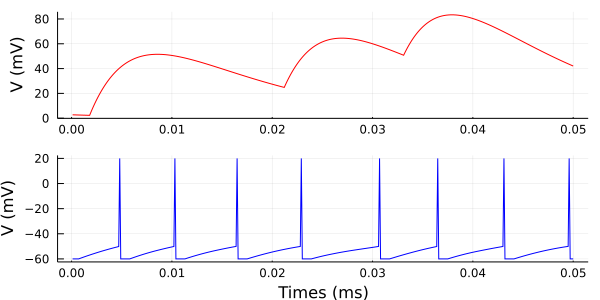

In [125]:
t = Array{Float32}(1:nt)*dt
p1 = plot(t, current[:, 1], color="red")
p2 = plot(t, v_arr2[:, 1], color="blue")
plot(p1, p2, 
    xlabel = ["" "Times (ms)"], 
    ylabel= ["V (mV)" "V (mV)"],
    layout = grid(2, 1, heights=[0.5, 0.5]), legend=false, size=(600,300))